In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import os
os.chdir('/kaggle/input/bank-customer-churn-prediction')
os.listdir()

['Churn_Modelling.csv']

In [3]:
data = pd.read_csv('Churn_Modelling.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Preprocessing

In [4]:
df = data.copy()
df.drop(columns=['RowNumber','CustomerId','Surname'], inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# checking for null values
overview = pd.concat((df.isnull().sum(),df.nunique(),df.dtypes), axis=1, keys=['Null count','cardinality','Data Type'])
display(overview.T)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Null count,0,0,0,0,0,0,0,0,0,0,0
cardinality,460,3,2,70,11,6382,4,2,2,9999,2
Data Type,int64,object,object,int64,int64,float64,int64,int64,int64,float64,int64


Clean data!

In [6]:
# checking correlation
df.corrwith(df.Exited).drop(columns = ['Exited']).sort_values(ascending=False)*100

Exited             100.000000
Age                 28.532304
Balance             11.853277
EstimatedSalary      1.209686
HasCrCard           -0.713777
Tenure              -1.400061
CreditScore         -2.709354
NumOfProducts       -4.781986
IsActiveMember     -15.612828
dtype: float64

***Inference:*** 
* **IsActiveMember** is has deep -ve correlation with a customer leaving (obvious). ie. Active/Regular customers are highily unlikely to leave.
* **Age** has a mild correlation with **Exited**. People with more age are likely to leave.
* Mild +ve correlation is observed for **Balanced** as well.

<Axes: >

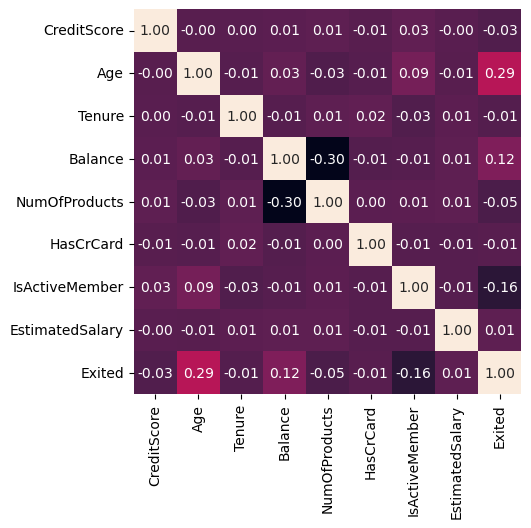

In [7]:
# better way of same representation
plt.figure(figsize=(5,5))
sns.heatmap(df.corr(), cbar=False, annot=True, fmt='.2f')

### Label Encoding

In [8]:
# label encoding for some categorical features
gender_labels = {'Female':0, 'Male':1}
geography_labels = {'France':0, 'Germany':1, 'Spain':2}
df.Gender = df.Gender.map(gender_labels)
df.Geography = df.Geography.map(geography_labels)

df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39,5,0.00,2,1,0,96270.64,0
9996,516,0,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,0,0,36,7,0.00,1,0,1,42085.58,1
9998,772,1,1,42,3,75075.31,2,1,0,92888.52,1


['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']


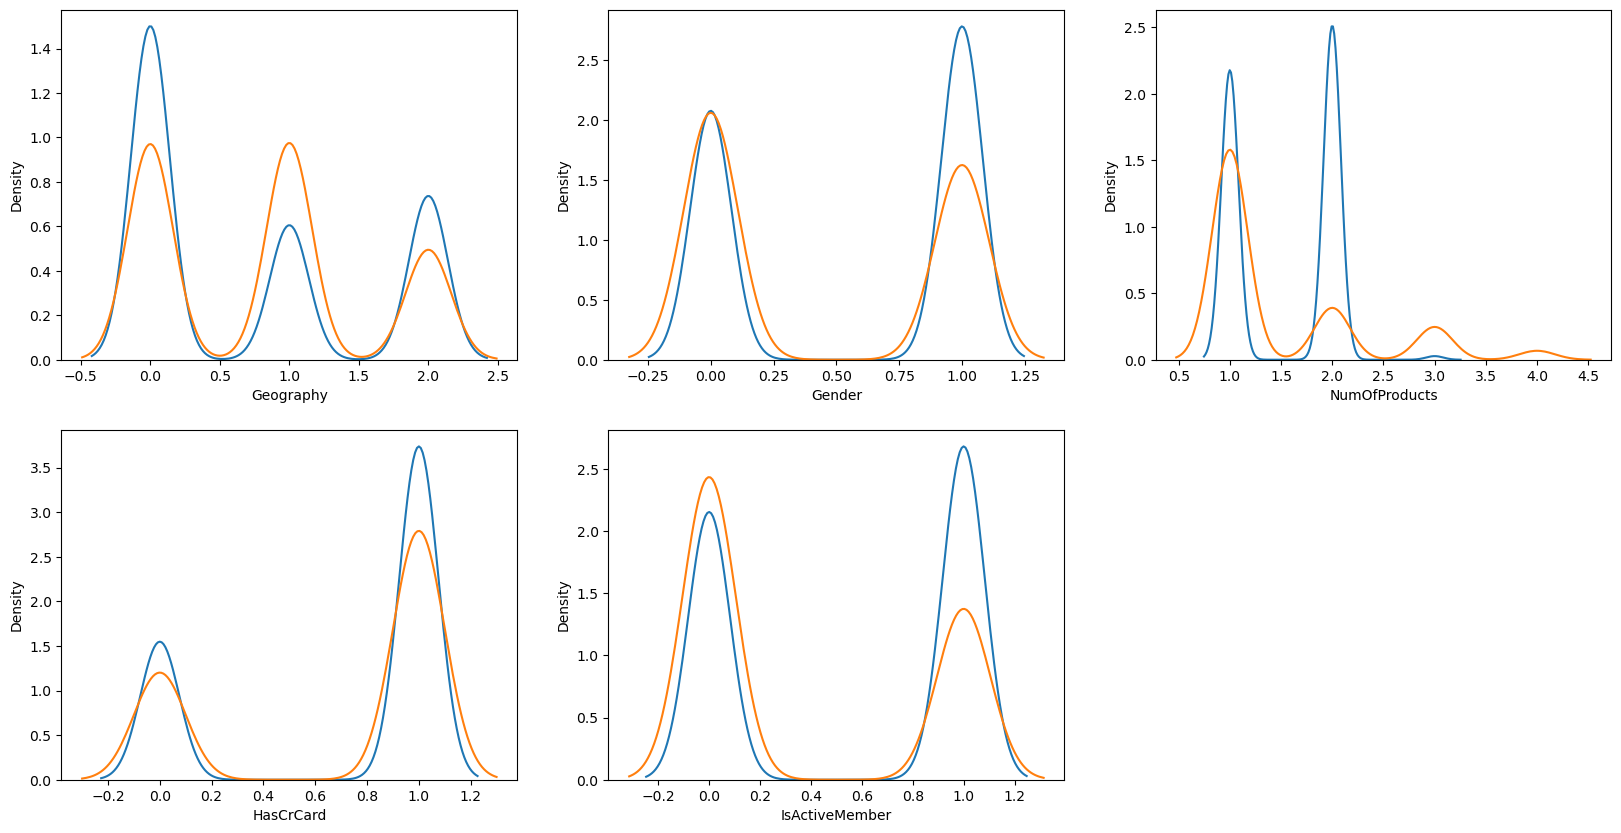

In [9]:
# checking class imbalances for categorical factors
cat = df.columns[df.nunique()<10].tolist()
cat.pop()
print(cat)
plt.figure(figsize=(20,10))
i=1
for factor in cat:
    plt.subplot(2,3,i)
    sns.distplot(df[factor].loc[df['Exited']==0], hist=False)
    sns.distplot(df[factor].loc[df['Exited']==1], hist=False)
    i+=1

All features are class balanced

In [10]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['Exited']).values, df.Exited.values, 
                                                    test_size=0.2, random_state=42)

## Machine Learning

### Finding Best Classifier: GridSearchCV

In [11]:
def result_grid(x_train, y_train, x_test, y_test):
    model_param_grid={
        'Logistic Regression':(LogisticRegression(max_iter=10000),{'C': [0.01, 0.1, 1, 10.0],
                                                                   'solver': ['liblinear','lbfgs','newton-cg']}),
        'KNN':(KNeighborsClassifier(),{'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]}),
#         'Naive Bayes':(MultinomialNB(),{'alpha': [0.1, 1.0, 10.0], 'fit_prior': [True,False]}),
#         'SVM':(LinearSVC(max_iter=10000),{'C': [0.01, 0.1, 1.0, 10.0]}),
        'Decision Tree':(DecisionTreeClassifier(max_depth=10),{'criterion': ['gini','entropy'], 'splitter':['best','random'],
                                                  'max_depth':[10,50,100,150,200,250,300,350,400]}),
        'Random Forest':(RandomForestClassifier(),{'n_estimators':[50,100,150,200]})
    }
    
    results=[]
    
    for name, (model,parameters) in model_param_grid.items():
        grid=GridSearchCV(model,parameters)
        
        print(f"Tuning for {name}")
        
        st=time.time()
        
        grid.fit(x_train,y_train) # fitting in GridSearchCV
        y_pred=grid.predict(x_test) # predicts using best hyperparameters
        acc=accuracy_score(y_test,y_pred) # best accuracy obtained
        
        en=time.time()
        
        net_time=en-st
        
        # printing best parameters:
        print(f"Best hyperparameters for {name}: {grid.best_params_}")
        print(f"Best obtined score for {name}: {grid.best_score_*100:.3f}%")
        print(f"Running time for {name}:{net_time:.3f}s")
        
        results.append([name,grid.best_params_,grid.best_score_*100,net_time])
        print('-'*100)
        print()
    
    result_df=pd.DataFrame(results, columns=['model_name','best_parameters','best_test_score','running_time'])
    result_df=result_df.style.highlight_max(subset=['best_test_score'], color = 'lightgreen')
    result_df=result_df.highlight_min(subset=['best_test_score'], color = 'pink')
    result_df=result_df.highlight_max(subset=['running_time'], color = 'pink')
    result_df=result_df.highlight_min(subset=['running_time'], color = 'lightgreen')
    return result_df

In [12]:
res = result_grid(x_train, y_train, x_test, y_test)
res

Tuning for Logistic Regression
Best hyperparameters for Logistic Regression: {'C': 10.0, 'solver': 'newton-cg'}
Best obtined score for Logistic Regression: 80.650%
Running time for Logistic Regression:13.804s
----------------------------------------------------------------------------------------------------

Tuning for KNN
Best hyperparameters for KNN: {'n_neighbors': 31}
Best obtined score for KNN: 79.450%
Running time for KNN:4.155s
----------------------------------------------------------------------------------------------------

Tuning for Decision Tree
Best hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'splitter': 'random'}
Best obtined score for Decision Tree: 84.138%
Running time for Decision Tree:4.386s
----------------------------------------------------------------------------------------------------

Tuning for Random Forest
Best hyperparameters for Random Forest: {'n_estimators': 150}
Best obtined score for Random Forest: 86.187%
Running ti

,model_name,best_parameters,best_test_score,running_time
0,Logistic Regression,"{'C': 10.0, 'solver': 'newton-cg'}",80.650000,13.804150
1,KNN,{'n_neighbors': 31},79.450000,4.155071
2,Decision Tree,"{'criterion': 'entropy', 'max_depth': 10, 'splitter': 'random'}",84.137500,4.385735
3,Random Forest,{'n_estimators': 150},86.187500,25.644313


General ML models can only get **86%** accuracy

## Deep Learning

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler

In [14]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8000, 10), (8000,), (2000, 10), (2000,))

In [15]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [16]:
m = Sequential()
m.add(Input(shape=(x_train.shape[1],1)))
m.add(SimpleRNN(11,activation='tanh'))
m.add(Dense(7,activation='relu'))
m.add(Dense(5,activation='relu'))
m.add(Dense(1,activation='sigmoid'))

m.compile(optimizer=Adam(learning_rate = 0.01),metrics=['accuracy'], loss='binary_crossentropy')
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 11)                143       
                                                                 
 dense (Dense)               (None, 7)                 84        
                                                                 
 dense_1 (Dense)             (None, 5)                 40        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [17]:
es = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, verbose=2)
rLR = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=2, mode="auto", min_delta=0.0001)
hist = m.fit(x=x_train, y=y_train, validation_data=(x_test,y_test), epochs=100, callbacks=[es,rLR])

Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 0.4531 - accuracy: 0.7945 - val_loss: 0.4327 - val_accuracy: 0.8035 - lr: 0.0100
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.4176 - accuracy: 0.8142 - val_loss: 0.3980 - val_accuracy: 0.8290 - lr: 0.0100
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.3968 - accuracy: 0.8328 - val_loss: 0.3902 - val_accuracy: 0.8415 - lr: 0.0100
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.3923 - accuracy: 0.8360 - val_loss: 0.3757 - val_accuracy: 0.8540 - lr: 0.0100
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.3765 - accuracy: 0.8475 - val_loss: 0.3815 - val_accuracy: 0.8460 - lr: 0.0100
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.3778 - accuracy: 0.8445 - val_loss: 0.3701 - val_accuracy: 0.8590 - lr: 0.0100
Epoch 7/100
250/250 [==============================] - 1s 3ms/st

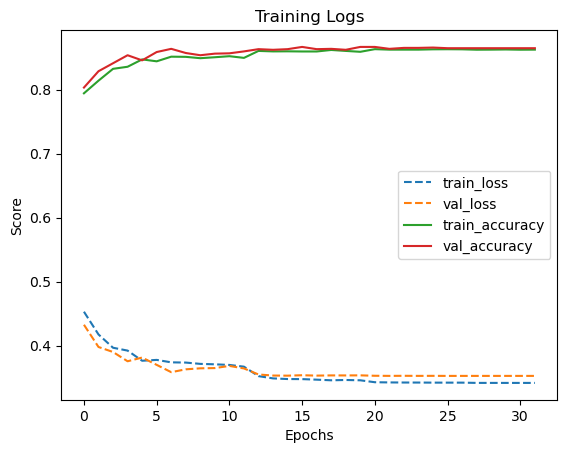

In [18]:
plt.plot(hist.history['loss'], label='train_loss', linestyle='dashed')
plt.plot(hist.history['val_loss'], label='val_loss', linestyle='dashed')
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Training Logs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.show()

In [19]:
m.evaluate(x_test,y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.3528 - accuracy: 0.8650


[0.35280704498291016, 0.8650000095367432]

Best ML Score: **Random Forest**(n_estimators=150), **86%**

Best DL Score: **86.3%**

**ANN** preformed slightly better than **Random Forest**.